# *Lipomyces starkeyi* ART medium optimization - initial design of experiment, parameter space exploration.

Medium components have a profound impact on production of microbial products. The effects of metals and vitamins on *L. starkeyi* malic acid production has been explored in a limited capacity - with the full composition space remaining to be explored. The Automated Recommendation Tool ([ART](https://www.nature.com/articles/s41467-020-18008-4)) is a machine learning based tool for bioproduction applications. The tool has been designed to provide both initial design of experiment and recommendations for further designs. The algorithm uses [Latin Hypercube Sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) to combinatorally explore the initial design space. A media optimization pipeline has been described using ART ([Zournas A et al., 2024: DOI: 10.21203/rs.3.rs-5072705/v1](https://www.researchsquare.com/article/rs-5072705/v1) that is leveraged here. 



This notebook leverages ART to create initial points to test for medium optimiation.  

## Inputs and output

**Required files to run this notebook:**
- `bounds_file.csv` - Contains the boundaries (i.e., high and low concentrations) to explore.
- `standard_media_file.csv` - Contains the medium components to be varied.

**File generated by running this notebook**
- `recommendations_initial.csv`

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')
    
from art.core import * 
import matplotlib.pyplot as plt


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/usr/local/art/.venv/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


## Parameter Specificiations.

### Defining media components and the number of instances (designs) to be created.

In [2]:
CYCLE = 1

user_params = {
    
    # file containing the lower and upper bounds to explore. 
    'bounds_file': f'mediumSetup/bounds_file.csv',
    
    # folder for output files.
    'output_file_path': f'mediumConcentrationOutputs/DBTL{CYCLE}', 
    
    # folder containing the standard media file. 
    # for Lipomyces - this is the LPM-40-50 (lipid production medium - 40 g carbon, 50 C/N ratio).
    'standard_media_file': f'mediumSetup/standard_media_file.csv',
}


Specify which components are included in the design space.

In [3]:
user_params['components'] = [
        #'glucose',
        #'xylose',
        'KH2PO4',
        'NH4Cl',
        'KCl',
        'MgSO4*7H2O',
        'ZnSO4·7H2O',
        'H3BO3',
        'MnCl2·4H2O',
        'FeSO4·7H2O',
        'CoCl2·6H2O',
        'CuSO4·5H20',
        'Na2MoO4·2H2O',
        'Na4EDTA',
        'biotin',
        'pyridoxine',
        'thiamine',
        'riboflavin',
        'para-aminobenzoic acid',
        'nicotinic acid'
]

Specify how many instances we are able to explore. This is the number of different medium combinations (i.e., 10 conditions with triplicates = 30 flasks). This number is excluding a control condition. 

In [4]:
user_params['n_instances'] = 50 # excluding the control condition.
user_params['n_replicates'] = 3  # number of replicates.

Read in the standard medium concentration.

In [5]:
standard_medium = pd.read_csv(user_params['standard_media_file']).set_index("Ingrediant")
standard_medium

,Standard concentration (LPM-40-50)
Ingrediant,
glucose,26.350000
xylose,13.650000
DMR hydrolysate,0.000000
KH2PO4,1.500000
NH4Cl,1.430000
KCl,0.500000
MgSO4*7H2O,0.500000
ZnSO4·7H2O,0.002250
H3BO3,0.011000


## Generate the control media.

For the initial design, we will use the standard media mix as the control media. In future design cycles, it is beneficial for learning purposes to have small variations in the standard concentration.
The code below will return the standard mix, but can be adapted to sample between 90 to 110% around the standard component concentrations.

Because we will have many conditions in the initial design - we will break up the samples into two experimental sets. The second experimental set will introduce this variation into the control sample.

In [6]:
ub = 1.0 # no variation - change to 1.1 for 110%
lb = 1.0 # no variation - change to 0.9 for 90% 

df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = standard_medium.loc[component]['Standard concentration (LPM-40-50)']
    df_control.at[0, component] = stand_conc*np.random.uniform(lb, ub)
    
    # second control for experiment set two. 
    df_control.at[1, component] = stand_conc*np.random.uniform(0.9, 1.1) # lb, ub


In [7]:
# DBTL 1 this will be the standard medium composition. 
df_control

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
0,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,0.0016,0.000085,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
1,1.373981,1.531092,0.480369,0.467291,0.002383,0.010578,0.005235,0.004532,0.001622,0.001647,0.000078,0.004902,0.000104,0.000099,0.000092,0.000101,0.000109,0.000105


## Generate the sampling for each medium condition.

Read the user specified bounds for each medium componenent:

In [8]:
df_bounds = pd.read_csv(user_params['bounds_file'], usecols=[0,1,2,3,4])
df_bounds

,Ingrediant,Standard concentration (LPM-40-50),Min,Max,Unnamed: 4
0,glucose,26.350000,NaN,NaN,NaN
1,xylose,13.650000,NaN,NaN,NaN
2,DMR hydrolysate,0.000000,NaN,NaN,NaN
3,KH2PO4,1.500000,2.500000e-01,5.000,*100 fold increase/decrease
4,NH4Cl,1.430000,5.000000e-01,5.000,*100 fold increase/decrease
5,KCl,0.500000,5.000000e-02,5.000,*100 fold increase/decrease
6,MgSO4*7H2O,0.500000,5.000000e-03,5.000,*100 fold increase/decrease
7,ZnSO4·7H2O,0.002250,2.250000e-05,0.500,*200 fold increase/decrease
8,H3BO3,0.011000,1.100000e-04,1.100,*100 fold increase/decrease
9,MnCl2·4H2O,0.005000,5.000000e-05,0.500,*100 fold increase/decrease


### weighting sample space.

When exploring a large concentration space that can go from M to mM concentrations (i.e., potentially elemental limitations), the drawn samples need a weighting factor to ensure include multiple samples in the mM range.

Because the lower condtions (i.e., 100-1000x fold decrease) are numerically closer than the 100-1000x higher concentrations - we needed to weight the sampling to correspond to the different conditons. 

We desired approximately a fraction of the samples to be below the standard composition. To do so, we force ART to sample the space from [-0.2 to 1.0] for every component. We then later map the drawn samples to the specified component range using interpolation. 

The exception is for KH2PO4 and NH4Cl - here we desired to sample more samples below the standard concentration to explore limited C/N and C/P ratios.

In [9]:
# create a new file for weighting. 
df_bounds_factor = pd.DataFrame(columns=['Variable', 'Min', 'Max'])
df_bounds_factor['Variable'] = user_params['components']


# sample space between -1 and 1 - which would allow you to even explore the space. If you were to lower the sampling space to -0.5 to 1.0, you would have a third of the samples in the negative range. 
# That third can then be mapped to the concentrations below your standard concentration or in the lower range without compromising the search space. 
df_bounds_factor['Min'] = -0.33/2*np.ones(18) # ranged varied.
df_bounds_factor.loc[df_bounds_factor['Variable']=='NH4Cl','Min'] = -0.5 #
df_bounds_factor.loc[df_bounds_factor['Variable']=='KH2PO4','Min'] = -0.5 #


df_bounds_factor['Max'] = np.ones(18)
df_bounds_factor

,Variable,Min,Max
0,KH2PO4,-0.500,1.0
1,NH4Cl,-0.500,1.0
2,KCl,-0.165,1.0
3,MgSO4*7H2O,-0.165,1.0
4,ZnSO4·7H2O,-0.165,1.0
5,H3BO3,-0.165,1.0
6,MnCl2·4H2O,-0.165,1.0
7,FeSO4·7H2O,-0.165,1.0
8,CoCl2·6H2O,-0.165,1.0
9,CuSO4·5H20,-0.165,1.0


Save the generated sampling bound file.

In [10]:
bounds_factor_file = f'mediumSetup/lipomycesStarkeyi_media_bounds_factor.csv'

df_bounds_factor.to_csv(bounds_factor_file)


### Non-weighted sampling space. 

To allow ART to sample from the space with no imposed limitations or weighting factors, we need to generate a file that has the correct input names for each factor. See sections below for more explanations. 

In [11]:
# non weighted files.
df_bounds_for_sampling = pd.DataFrame(columns=['Variable', 'Min', 'Max'])
df_bounds_for_sampling['Variable'] = user_params['components']
for comp in user_params['components']:
    df_bounds_for_sampling.loc[df_bounds_for_sampling['Variable']==comp,'Min'] = df_bounds[df_bounds['Ingrediant']==comp]['Min'].values
    df_bounds_for_sampling.loc[df_bounds_for_sampling['Variable']==comp,'Max'] = df_bounds[df_bounds['Ingrediant']==comp]['Max'].values

# df_bounds_for_sampling.
bounds_file = f'mediumSetup/bounds_file_for_non_weighted_sampling.csv'
df_bounds_for_sampling.to_csv(bounds_file)
df_bounds_for_sampling

,Variable,Min,Max
0,KH2PO4,0.25,5.0
1,NH4Cl,0.5,5.0
2,KCl,0.05,5.0
3,MgSO4*7H2O,0.005,5.0
4,ZnSO4·7H2O,0.000023,0.5
5,H3BO3,0.00011,1.1
6,MnCl2·4H2O,0.00005,0.5
7,FeSO4·7H2O,0.00005,0.5
8,CoCl2·6H2O,0.000017,0.5
9,CuSO4·5H20,0.000016,0.5



Define a dictionary that contains the settings that ART will use to find the recommended designs:



In [12]:
art_params = {
    'input_vars': user_params['components'],
    
    # uncomment line below for using weighted sample space
    'bounds_file': bounds_factor_file, # weighted file
    
    ## uncomment line for absolute factors
    # 'bounds_file':bounds_file,
    
    'num_recommendations': user_params['n_instances'],    # one of them will be wild type
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': 45,                                               # seed for number random generator
    'output_directory': user_params['output_file_path']  # directory to store this output
}


With the configuration stored in `art_params`, we now run ART:

In [13]:
art = RecommendationEngine(**art_params)
art_recommendations = art.recommendations.copy()
art_recommendations.tail()

/code/ManuscriptVerify/../art/core.py:648: UserWarning: bounds_file is a deprecated parameter. Update your code to use bounds instead.  bounds_file will be removed in a future ART version.
  warnings.warn(
/code/ManuscriptVerify/../art/core.py:465: UserWarning: output_directory is a deprecated alias for output_dir. Update your code to use output_dir instead.  The output_directory alias will be removed in a future ART version.
  warnings.warn(


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
45,0.800513,-0.293288,0.160040,0.845906,0.250676,-0.158539,-0.108625,-0.008044,0.763428,0.397100,0.164810,-0.093038,0.329532,0.838131,-0.061748,0.219079,-0.074805,0.780297
46,0.011530,0.792256,0.878007,0.142615,0.277216,0.121820,0.153660,0.765168,0.579296,0.876060,0.724237,0.203810,-0.005866,0.154242,0.986921,0.687328,0.813669,0.004811
47,-0.060917,0.718818,0.251245,0.045796,-0.122494,0.546878,0.048177,-0.106350,0.054173,0.985957,0.619426,0.233486,0.969402,0.724834,0.500453,0.061876,0.683157,0.347603
48,0.326694,0.221421,0.398283,-0.150117,0.953328,0.372659,0.939744,0.106437,0.399170,-0.072949,0.512277,-0.038889,0.706505,0.801009,0.159538,-0.107827,0.318106,-0.014967
49,0.551091,-0.047652,0.729177,0.201706,0.084595,0.356795,0.781886,0.868306,0.834987,0.729397,0.144407,0.315083,-0.059377,0.444453,0.630521,0.616059,0.154594,0.618212


### Weighted sampling Space. 

Map the sampled space to each component bounds into our factors using interpolation. For samples drawn, map the following way

If the value is negative - we map the value to its corresponding concentration that using the ranges **below** the standard concentration. 

if value is [-0.165].  

$ Value/sampling range * (Range of lower bound to standard component) + standard concentration$:

Example for KCl:  

$\frac{-0.165}{0 - -0.165} * (0.5 - 0.05) + 0.5 = 0.05$

if value is positive [1]

Value * (Range of higher bound to standard component) + standard concentration:

Example for KCl
$\frac{1}{1 - 0} * (5 - 0.5) + 0.5 = 5$




### Generate weighted samples

In [14]:

# factor = {}


## factors 
df_ranges_factors = art_recommendations.copy()

# temporary holders for performing calculations shown above. 
component_range_low = {}
component_range_high = {}
component_std = {}


for comp in (user_params['components']):

    # holders for the component high and low ranges.
    # the range from the standard to the high value. 
    component_range_high[comp] = {df_bounds[df_bounds['Ingrediant']==comp]['Max'].values[0]-standard_medium.loc[comp, 'Standard concentration (LPM-40-50)']}
    
    # the range from the standard to the low value. 
    component_range_low[comp] = {standard_medium.loc[comp, 'Standard concentration (LPM-40-50)']-df_bounds[df_bounds['Ingrediant']==comp]['Min'].values[0]}
    

for ind in art_recommendations.index:
    for comp in art_recommendations.columns:
        
        # ranges
        if art_recommendations.at[ind, comp]<0:
            
            # interpolate the negative range. Sampled value / sample range * component range + standard
            # lowest value in the bounds factor file.
            low_factor = -1*df_bounds_factor[df_bounds_factor.Variable==comp].Min.values[0]
            df_ranges_factors.at[ind,comp] = art_recommendations.at[ind, comp]/low_factor*list(component_range_low[comp])[0]+standard_medium.loc[comp, 'Standard concentration (LPM-40-50)']
        else:
            
            # interpolate the positive range. Sampled value / sample range * component range + standard
            df_ranges_factors.at[ind,comp] = art_recommendations.at[ind, comp]*list(component_range_high[comp])[0]+standard_medium.loc[comp, 'Standard concentration (LPM-40-50)']


Transform these factors into our concentrations:

In [15]:
# factors 
art_recommendatiosn_copy = art_recommendations.copy()

for comp in art_recommendations.columns:
    stand_conc = standard_medium.loc[comp, 'Standard concentration (LPM-40-50)']
    art_recommendatiosn_copy.loc[:, comp]  = df_ranges_factors.loc[:, comp]

### Non-weighted sample space.

uncomment the line below to allow for unweightd factors.

In [16]:
# art_recommendatiosn_copy = art_recommendations.copy()

## Expamine art recommendations. 

In [17]:
art_recommendatiosn_copy.head()

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
0,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
1,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175
2,3.037440,1.831617,2.666755,4.031676,0.075208,1.050843,0.109357,0.031849,0.487003,0.073458,0.005607,0.000056,0.005642,0.007673,0.003549,0.010288,0.002308,0.006370
3,0.328778,2.887089,4.093005,0.452409,0.318256,0.006774,0.345719,0.423287,0.359819,0.026142,0.011016,0.539794,0.004529,0.007755,0.000519,0.003431,0.007448,0.000056
4,2.561391,0.647195,2.725485,0.421551,0.098658,0.715603,0.291880,0.108269,0.311358,0.052499,0.071654,1.292270,0.000105,0.000050,0.005726,0.071396,0.002937,0.009516


### Cycle 1

In [25]:
df_target = art_recommendatiosn_copy.iloc[:52]
df_target = art_recommendatiosn_copy.append(df_control.iloc[0]).reset_index(drop=True)
df_target

/tmp/ipykernel_83/2469331360.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_target = art_recommendatiosn_copy.append(df_control.iloc[0]).reset_index(drop=True)


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
0,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
1,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175
2,3.037440,1.831617,2.666755,4.031676,0.075208,1.050843,0.109357,0.031849,0.487003,0.073458,0.005607,0.000056,0.005642,0.007673,0.003549,0.010288,0.002308,0.006370
3,0.328778,2.887089,4.093005,0.452409,0.318256,0.006774,0.345719,0.423287,0.359819,0.026142,0.011016,0.539794,0.004529,0.007755,0.000519,0.003431,0.007448,0.000056
4,2.561391,0.647195,2.725485,0.421551,0.098658,0.715603,0.291880,0.108269,0.311358,0.052499,0.071654,1.292270,0.000105,0.000050,0.005726,0.071396,0.002937,0.009516
5,3.607083,0.740823,2.165658,0.532325,0.338557,0.162131,0.090048,0.107465,0.156323,0.082102,0.000070,2.015757,0.000034,0.000723,0.008021,0.030737,0.000634,0.002987
6,3.642639,1.445946,2.958516,0.289307,0.490812,0.388578,0.003085,0.443965,0.300930,0.098254,0.000059,0.648420,0.000596,0.009411,0.002353,0.010807,0.000439,0.006652
7,1.174374,1.132287,3.931174,1.490559,0.001889,0.002489,0.001100,0.067006,0.325882,0.321971,0.065100,0.044155,0.005021,0.005998,0.003962,0.029002,0.001959,0.001494
8,0.625272,4.184652,0.096926,1.268906,0.083475,0.473491,0.123687,0.005749,0.233131,0.117227,0.032899,1.800571,0.002907,0.000037,0.006932,0.038097,0.000029,0.000042
9,1.290563,1.038438,2.523825,2.937331,0.464555,0.004627,0.168052,0.299079,0.391934,0.354270,0.079418,0.001149,0.008672,0.003816,0.000081,0.057004,0.003530,0.003144


In [26]:
df_control


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
0,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,0.0016,0.000085,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
1,1.373981,1.531092,0.480369,0.467291,0.002383,0.010578,0.005235,0.004532,0.001622,0.001647,0.000078,0.004902,0.000104,0.000099,0.000092,0.000101,0.000109,0.000105


### Checking the distribution of initial designs

In [27]:
def designs_pairwise(art, df,standard):

    dim = art.num_input_var

    plt.style.use(["seaborn-talk"])

    fig = plt.figure(figsize=(50, 50))
    fig.patch.set_facecolor("white")

    X = df.values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="r",
                edgecolor="r",
                marker="+",
                lw=1,
                label="Train data",
            )
            # print(var1)
            # print(var2)
            ax.scatter(
                standard[var1],
                standard[var2],
                c="k",
                marker=".",
                s=126,
                lw=1,
                label="Standard",
            )
            
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    # fig.savefig(f'{art.outDir}/l.png', transparent=False, dpi=300)

### Checking distribution of weighted graph_parameter space

/tmp/ipykernel_83/3429704134.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-talk"])
/tmp/ipykernel_83/3429704134.py:16: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


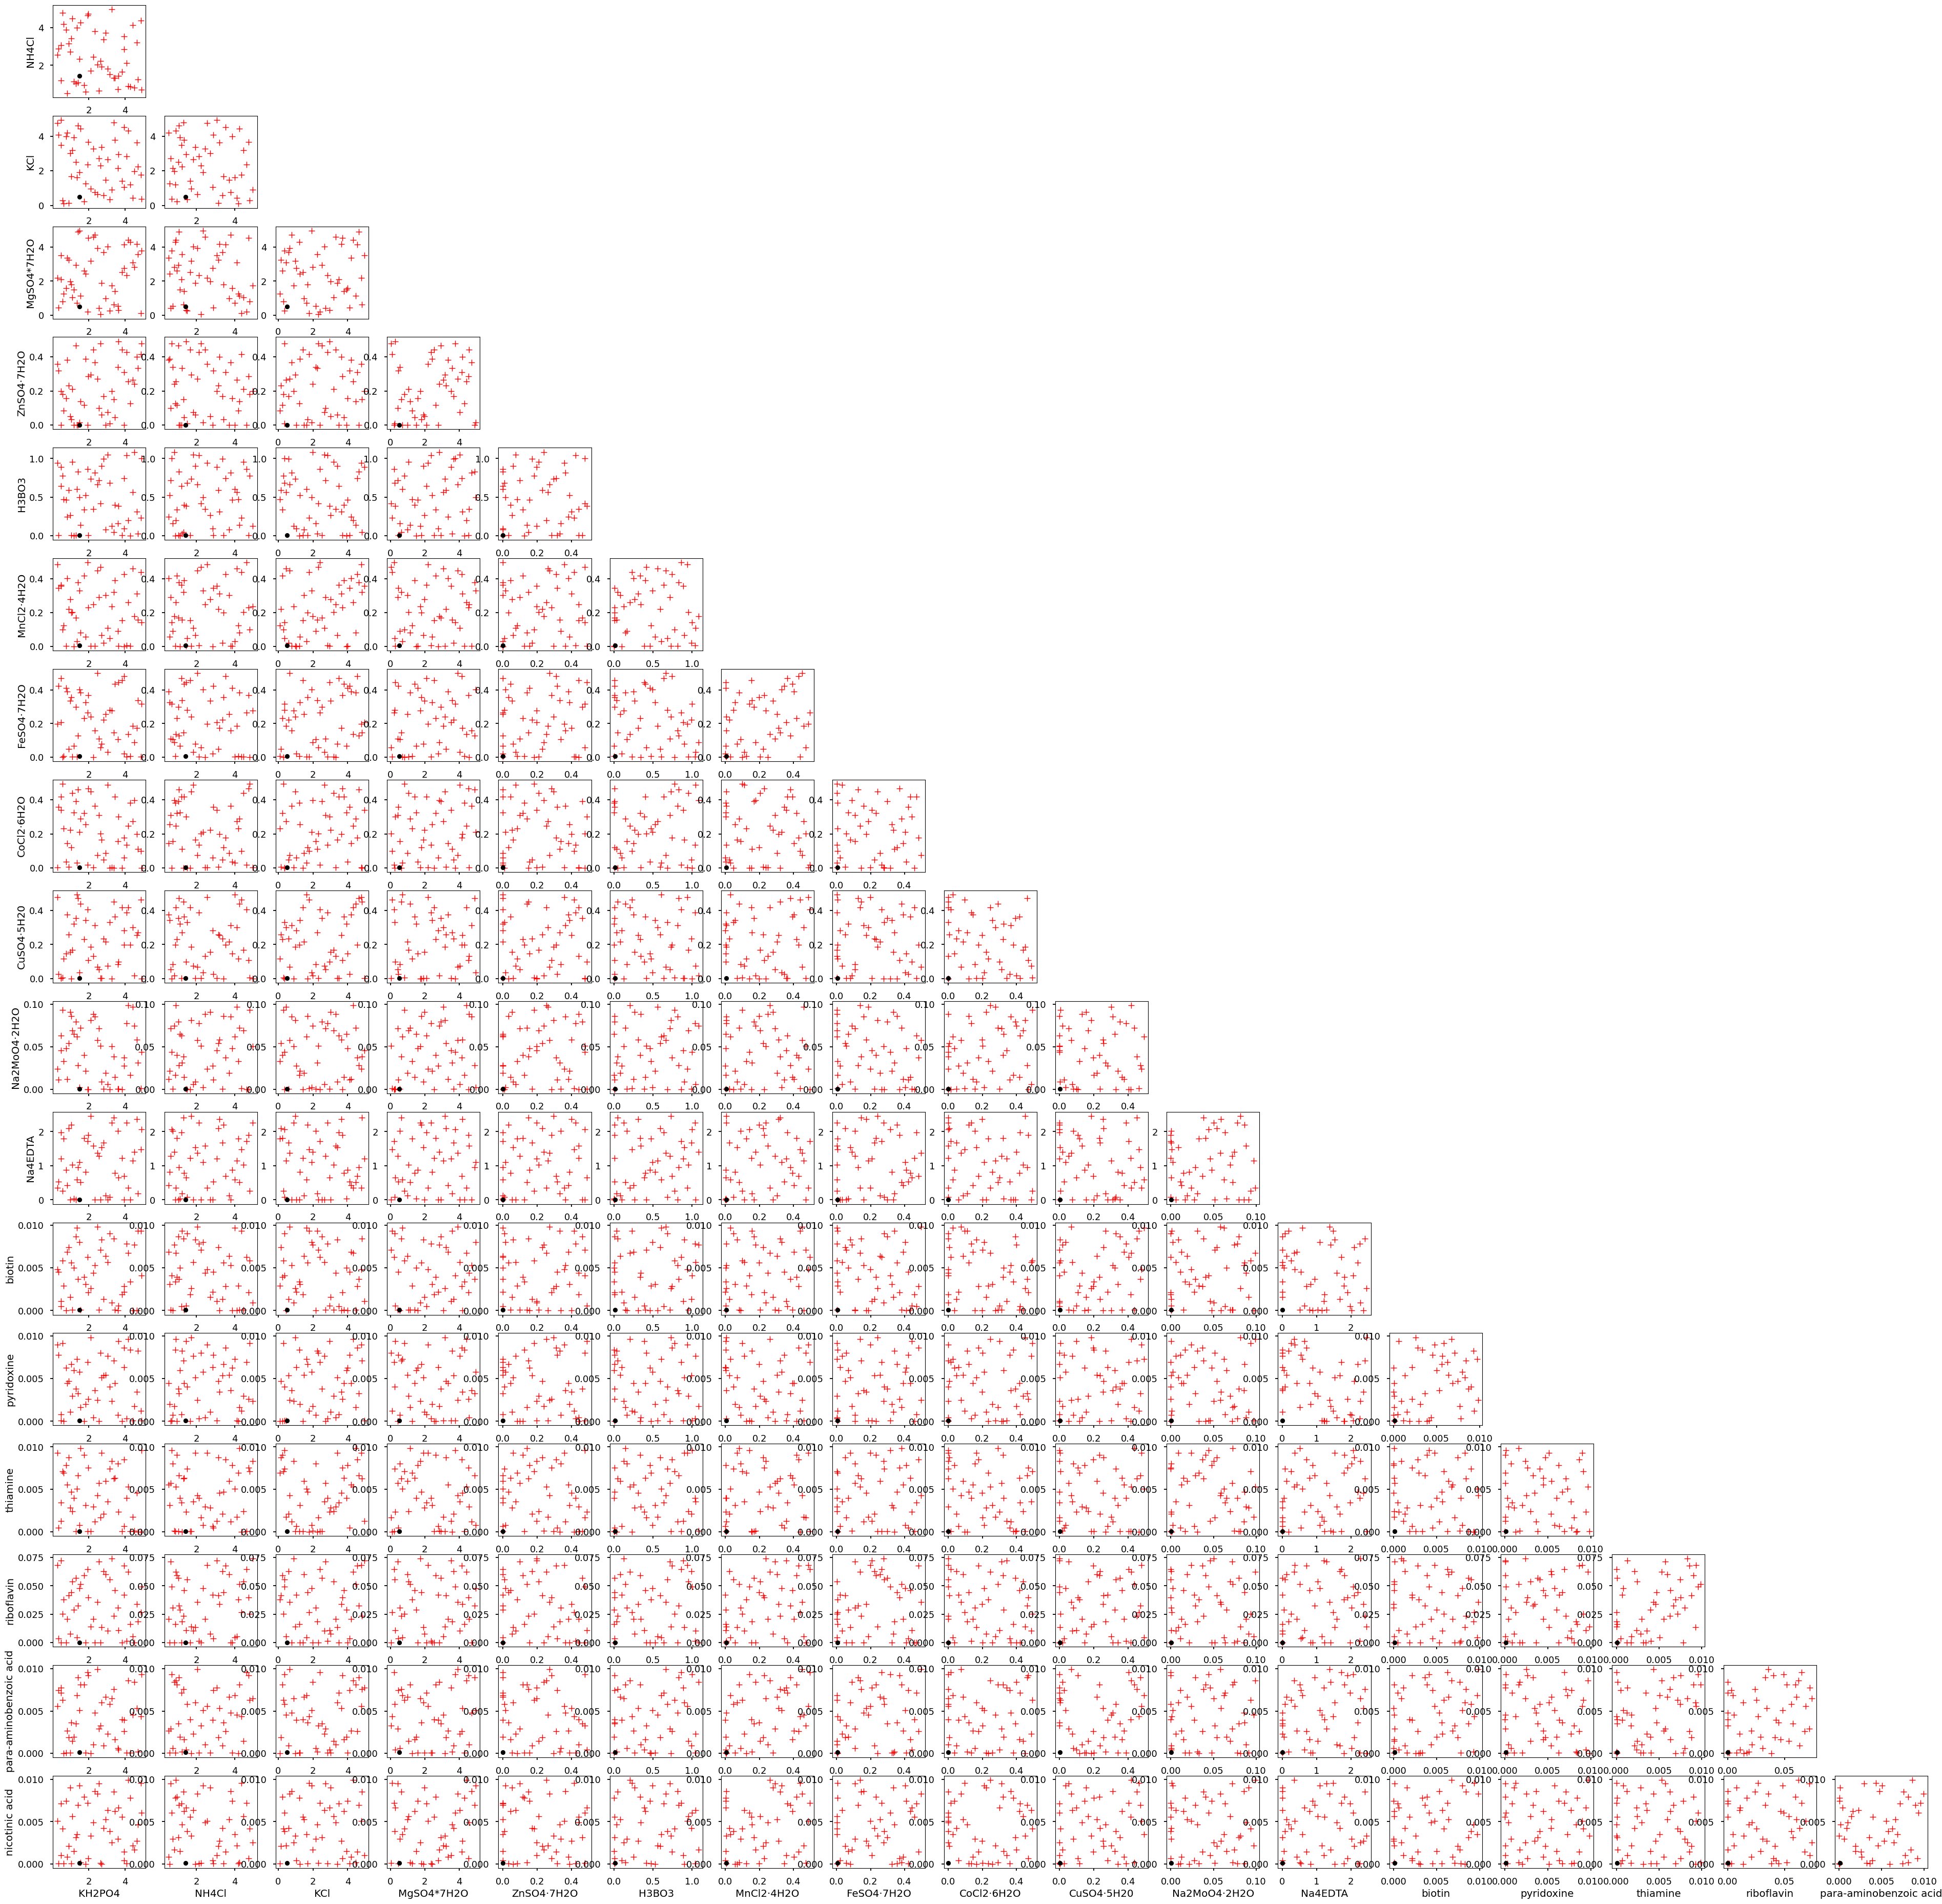

In [28]:
designs_pairwise(art, art_recommendatiosn_copy,df_control.iloc[0])

### Non-weighted graph

In [29]:
# designs_pairwise(art, art_recommendatiosn_copy,df_control.iloc[0])

## Saving the generated designs 

Running experiments these in two separate batch, so will evenly split the sampls between the conditions. 

In [30]:
# experimental set 1
df_target_1 = art_recommendatiosn_copy.iloc[:25]

# df_target_1 = art_recommendatiosn_copy.append(df_control.iloc[0]).reset_index(drop=True)
df_target_1= df_target_1.append(df_control.iloc[0]).reset_index(drop=True)
df_target_1

/tmp/ipykernel_83/994853837.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_target_1= df_target_1.append(df_control.iloc[0]).reset_index(drop=True)


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
0,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
1,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175
2,3.037440,1.831617,2.666755,4.031676,0.075208,1.050843,0.109357,0.031849,0.487003,0.073458,0.005607,0.000056,0.005642,0.007673,0.003549,0.010288,0.002308,0.006370
3,0.328778,2.887089,4.093005,0.452409,0.318256,0.006774,0.345719,0.423287,0.359819,0.026142,0.011016,0.539794,0.004529,0.007755,0.000519,0.003431,0.007448,0.000056
4,2.561391,0.647195,2.725485,0.421551,0.098658,0.715603,0.291880,0.108269,0.311358,0.052499,0.071654,1.292270,0.000105,0.000050,0.005726,0.071396,0.002937,0.009516
5,3.607083,0.740823,2.165658,0.532325,0.338557,0.162131,0.090048,0.107465,0.156323,0.082102,0.000070,2.015757,0.000034,0.000723,0.008021,0.030737,0.000634,0.002987
6,3.642639,1.445946,2.958516,0.289307,0.490812,0.388578,0.003085,0.443965,0.300930,0.098254,0.000059,0.648420,0.000596,0.009411,0.002353,0.010807,0.000439,0.006652
7,1.174374,1.132287,3.931174,1.490559,0.001889,0.002489,0.001100,0.067006,0.325882,0.321971,0.065100,0.044155,0.005021,0.005998,0.003962,0.029002,0.001959,0.001494
8,0.625272,4.184652,0.096926,1.268906,0.083475,0.473491,0.123687,0.005749,0.233131,0.117227,0.032899,1.800571,0.002907,0.000037,0.006932,0.038097,0.000029,0.000042
9,1.290563,1.038438,2.523825,2.937331,0.464555,0.004627,0.168052,0.299079,0.391934,0.354270,0.079418,0.001149,0.008672,0.003816,0.000081,0.057004,0.003530,0.003144


In [31]:
# experimental set 2
# del(df_target_1)
df_target_2 = art_recommendatiosn_copy.iloc[25:]

# df_target_1 = art_recommendatiosn_copy.append(df_control.iloc[0]).reset_index(drop=True)
df_target_2= df_target_2.append(df_control.iloc[1]).reset_index(drop=True)
df_target_2

/tmp/ipykernel_83/1951196860.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_target_2= df_target_2.append(df_control.iloc[1]).reset_index(drop=True)


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
0,4.087562,2.131518,2.837720,2.355412,0.425586,1.040215,0.005711,0.002432,0.134524,0.388366,0.077741,2.260173,0.007791,0.000308,0.004017,0.001244,0.000074,0.000081
1,3.264100,4.963607,0.902964,1.747564,0.198562,0.128188,0.235765,0.275801,0.001105,0.000456,0.050479,2.270071,0.000928,0.002384,0.008329,0.073973,0.006465,0.002559
2,2.694586,1.935402,3.386307,1.902572,0.060755,0.902309,0.068073,0.080835,0.166144,0.001436,0.008608,1.535970,0.008292,0.005146,0.009271,0.013445,0.005994,0.000020
3,2.920672,3.712866,1.487986,1.000375,0.000886,0.080041,0.301942,0.256788,0.086508,0.217422,0.018875,0.124829,0.006361,0.005446,0.005990,0.060211,0.006645,0.005270
4,1.477399,2.327461,1.910026,4.959215,0.016501,0.495989,0.331430,0.403535,0.210168,0.036720,0.002392,1.099494,0.007979,0.005776,0.000794,0.047976,0.005086,0.009276
5,3.390382,1.329714,4.804244,0.622828,0.151476,0.048410,0.321441,0.144881,0.000464,0.450345,0.038274,2.409319,0.008392,0.007100,0.006289,0.023669,0.007584,0.008524
6,2.829559,3.375253,0.595536,3.683590,0.170045,0.997799,0.021945,0.222831,0.048223,0.235560,0.000074,1.682265,0.001341,0.005376,0.002127,0.062897,0.000898,0.004260
7,1.029431,3.416140,1.673030,1.790325,0.033664,0.005900,0.198372,0.356362,0.119610,0.000223,0.086222,2.201758,0.005617,0.006706,0.004722,0.044397,0.003613,0.000064
8,0.764885,3.881332,3.990435,1.590528,0.156699,0.464344,0.002425,0.410122,0.036425,0.146321,0.048072,0.882444,0.000009,0.006254,0.007827,0.000067,0.000039,0.007469
9,1.103075,4.476740,3.200132,1.038642,0.211035,0.954916,0.203187,0.003162,0.438900,0.168032,0.069394,1.033092,0.000073,0.002974,0.002438,0.053740,0.001451,0.005649


Include all replicates: 

In [32]:
df_target_1_rep = df_target_1.loc[df_target_1.index.repeat(user_params['n_replicates'])]
df_target_2_rep = df_target_2.loc[df_target_2.index.repeat(user_params['n_replicates'])]
df_target_1_rep


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
0,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
0,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
0,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
1,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175
1,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,4.724037,1.249027,2.252034,3.586508,0.332878,0.030841,0.156537,0.339472,0.112268,0.269445,0.031145,0.186250,0.009306,0.008276,0.000003,0.018430,0.000178,0.004673
24,4.724037,1.249027,2.252034,3.586508,0.332878,0.030841,0.156537,0.339472,0.112268,0.269445,0.031145,0.186250,0.009306,0.008276,0.000003,0.018430,0.000178,0.004673
25,1.500000,1.430000,0.500000,0.500000,0.002250,0.011000,0.005000,0.005000,0.001700,0.001600,0.000085,0.005000,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100
25,1.500000,1.430000,0.500000,0.500000,0.002250,0.011000,0.005000,0.005000,0.001700,0.001600,0.000085,0.005000,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100


rename the samples for ease of downstream processing.

In [33]:
well_rows = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
well_columns = '123'

In [34]:
df_target_1_well = df_target_1_rep.copy()
df_target_2_well = df_target_2_rep.copy()

well_names = [f'{row}{column}'  for row in well_rows for column in well_columns]

df_target_1_well['Well'] = well_names
df_target_1_well = df_target_1_well.set_index(['Well'])
df_target_2_well['Well'] = well_names
df_target_2_well = df_target_2_well.set_index(['Well'])
df_target_1_well

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
Well,,,,,,,,,,,,,,,,,,
A1,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
A2,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
A3,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
B1,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175
B2,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y2,4.724037,1.249027,2.252034,3.586508,0.332878,0.030841,0.156537,0.339472,0.112268,0.269445,0.031145,0.186250,0.009306,0.008276,0.000003,0.018430,0.000178,0.004673
Y3,4.724037,1.249027,2.252034,3.586508,0.332878,0.030841,0.156537,0.339472,0.112268,0.269445,0.031145,0.186250,0.009306,0.008276,0.000003,0.018430,0.000178,0.004673
Z1,1.500000,1.430000,0.500000,0.500000,0.002250,0.011000,0.005000,0.005000,0.001700,0.001600,0.000085,0.005000,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100


# save files. 

In [35]:
df_target_1

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
0,4.663187,3.194130,3.633665,4.175931,0.400705,0.312118,0.311629,0.173818,0.197759,0.254841,0.058411,2.368982,0.000016,0.003470,0.004595,0.034002,0.005316,0.002739
1,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,0.063478,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175
2,3.037440,1.831617,2.666755,4.031676,0.075208,1.050843,0.109357,0.031849,0.487003,0.073458,0.005607,0.000056,0.005642,0.007673,0.003549,0.010288,0.002308,0.006370
3,0.328778,2.887089,4.093005,0.452409,0.318256,0.006774,0.345719,0.423287,0.359819,0.026142,0.011016,0.539794,0.004529,0.007755,0.000519,0.003431,0.007448,0.000056
4,2.561391,0.647195,2.725485,0.421551,0.098658,0.715603,0.291880,0.108269,0.311358,0.052499,0.071654,1.292270,0.000105,0.000050,0.005726,0.071396,0.002937,0.009516
5,3.607083,0.740823,2.165658,0.532325,0.338557,0.162131,0.090048,0.107465,0.156323,0.082102,0.000070,2.015757,0.000034,0.000723,0.008021,0.030737,0.000634,0.002987
6,3.642639,1.445946,2.958516,0.289307,0.490812,0.388578,0.003085,0.443965,0.300930,0.098254,0.000059,0.648420,0.000596,0.009411,0.002353,0.010807,0.000439,0.006652
7,1.174374,1.132287,3.931174,1.490559,0.001889,0.002489,0.001100,0.067006,0.325882,0.321971,0.065100,0.044155,0.005021,0.005998,0.003962,0.029002,0.001959,0.001494
8,0.625272,4.184652,0.096926,1.268906,0.083475,0.473491,0.123687,0.005749,0.233131,0.117227,0.032899,1.800571,0.002907,0.000037,0.006932,0.038097,0.000029,0.000042
9,1.290563,1.038438,2.523825,2.937331,0.464555,0.004627,0.168052,0.299079,0.391934,0.354270,0.079418,0.001149,0.008672,0.003816,0.000081,0.057004,0.003530,0.003144


In [36]:
# experiment 1a.
file = f"{user_params['output_file_path']}/target_concentrations_withReps_DBTL_1a.csv"
df_target_1_well.to_csv(file)

file = f"{user_params['output_file_path']}/target_concentrations__DBTL_1a.csv"

df_target_1.to_csv(file)

# experiment 1b.
file = f"{user_params['output_file_path']}/target_concentrations_withReps_DBTL_1b.csv"
df_target_2_well.to_csv(file)

file = f"{user_params['output_file_path']}/target_concentrations__DBTL_1b.csv"
df_target_2.to_csv(file)




In [37]:
# full design space.

df_target = df_target.append(df_control.iloc[1]).reset_index(drop=True)
# df_target['biotin']

/tmp/ipykernel_83/1908599395.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_target = df_target.append(df_control.iloc[1]).reset_index(drop=True)


In [38]:
file = f"{user_params['output_file_path']}/target_concentrations_allConditions_DBTL_1.csv"
df_target.to_csv(file)